In [2]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [4]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [5]:
sns.set_context('poster')

In [6]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [7]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [8]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [9]:
df = pd.read_pickle('CCPA.pkl.gz')

In [10]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [11]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

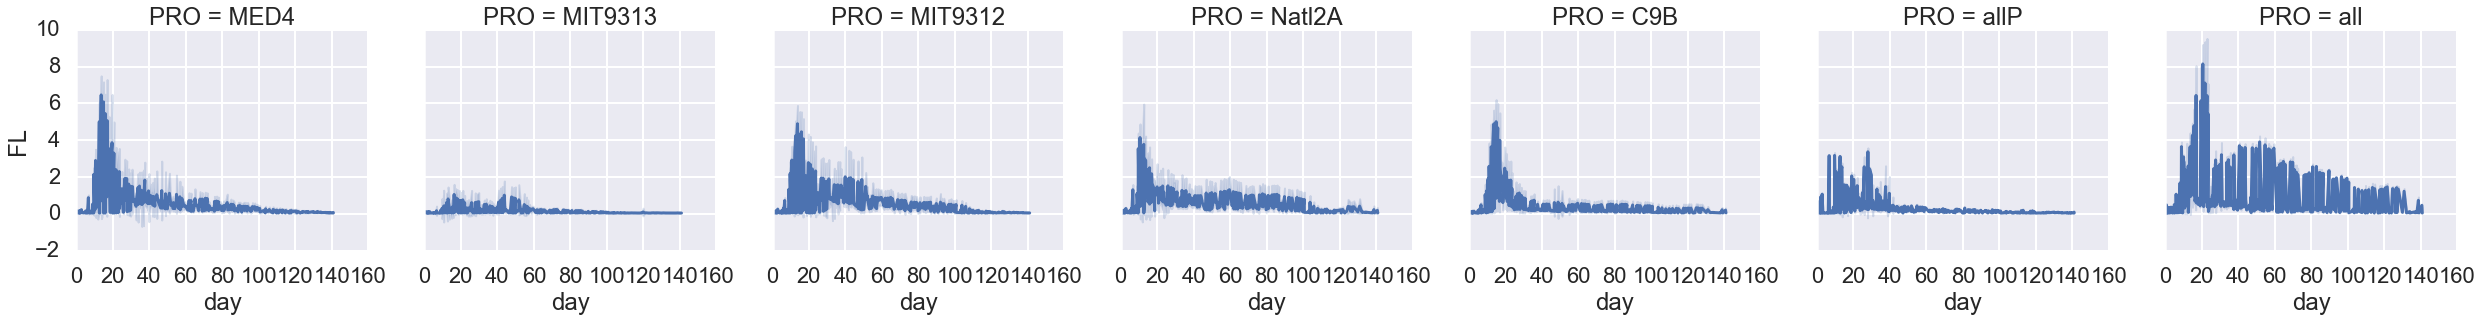

In [12]:
sns.relplot(data=df, x='day', y='FL', kind='line',  col='PRO', ci='sd')

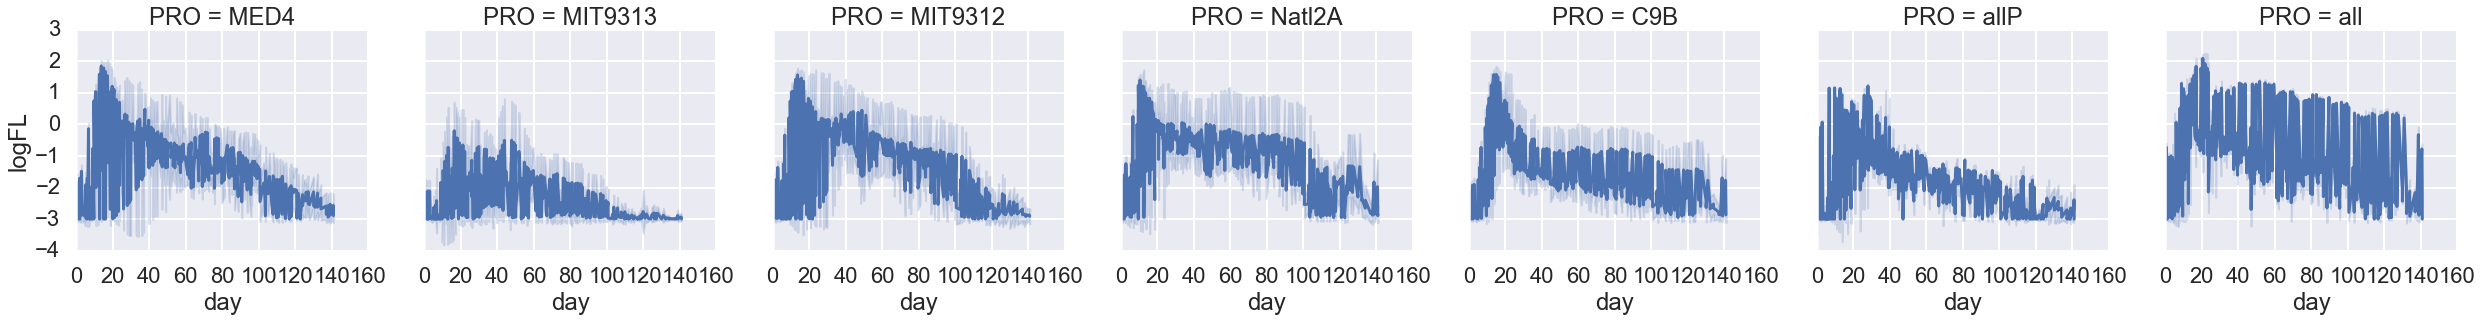

In [13]:
sns.relplot(data=df, x='day', y='logFL', kind='line',  col='PRO', ci='sd')

In [14]:
d = cp.generate_decay(dfc, scale=False)

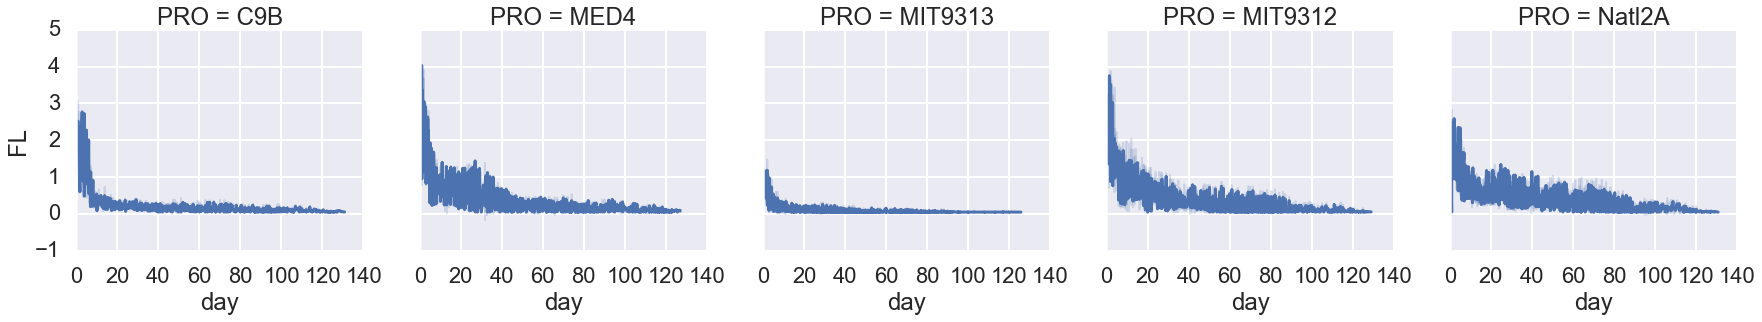

In [15]:
sns.relplot(data=d, x='day', y='FL', kind='line',  col='PRO', ci='sd')

In [16]:
def apply_fit(df, model, print_popt=True):
    x = df['day']
    y = df['FL']
    p0= [0.5, 0.5,0.5,0.5]
    y_pred = 0
    y_pred_p0 = 0
    score = 0
    popt = []
    score_p0 = 0
    popt_p0 = []
    
    try:
        popt, pcov = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, #p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred = model (x, *popt)
        score = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    try:
        popt_p0, pcov_p0 = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred_p0 = model (x, *popt)
        score_p0 = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    if score_p0 > score:
        score = score_p0
        y_pred = y_pred_p0
        popt = popt_p0
    
        
    if print_popt:
        print(popt)

    df['y_pred'] = y_pred
    for i in range(len(popt)):
        df[f'popt_{i}'] = popt[i]

        
    return df


In [17]:
def apply_fit_2(df, model):
    x = df['day']
    y = df['FL']
    popt, pcov = curve_fit(model, x, y, #method='dogbox', loss='soft_l1', f_scale=0.1, 
                          # bounds = (0, np.inf)
                          )
    y_pred = model (x, *popt)
    print(popt)
    df['y_pred'] = y_pred
    return df


In [18]:
# fit all functions
functions = {'cubic' : cp.model_cubic, 
             'exponential' :cp.model_exponential,
             'hyperbolic' : cp.model_hyperbolic,
             #'exponential_segmented' : cp.model_exponential_segmented,
             'gompertz' : cp.model_gompertz,
             'harmonic' : cp.model_harmonic,
             'linear' : cp.model_linear,
             'logistic3' : cp.model_logistic3,
             'logistic4' : cp.model_logistic4,
             'loglogistic' : cp.model_loglogistic,
             'rodbard4' : cp.model_rodbard4,
             'scurve' : cp.model_scurve,
            }
dfe = d.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
for n in method_cols:
    f = functions[n]
    print(n)
    t = dfe.groupby('experiment_sample').apply(lambda x: apply_fit(x, f))
    dfe[n] = t['y_pred']


exponential
[3.13796447 0.28850185 0.23243319 1.        ]
[3.13796447 0.28850185 0.23243319 1.        ]
[3.15524358 0.28854413 0.21355025 1.        ]
[3.02820901 0.31943397 0.21943086 1.        ]
[1.56523794 0.02973404 0.0101065  1.        ]
[2.16359439 0.05547607 0.08243461 1.        ]
[ 1.46498476  0.02856285 -0.00302461  1.        ]
[0.70896018 0.24196126 0.05355432 1.        ]
[0.64337105 0.2602097  0.05695251 1.        ]
[0.77837506 0.12013545 0.06836048 1.        ]
[1.59570521 0.04115569 0.08778657 1.        ]
[1.78026852 0.035824   0.06715133 1.        ]
[1.61370546 0.03717757 0.07959601 1.        ]
[1.46383434 0.13807328 0.32322181 1.        ]
[2.08360193 0.15555808 0.29164986 1.        ]
[1.84196683 0.09971272 0.32720671 1.        ]
[2.48632859 0.18081383 0.09015241 1.        ]
[2.37230466 0.18465669 0.07764617 1.        ]
[2.27181082 0.14768547 0.07678043 1.        ]
[1.57268591 0.03345777 0.08625722 1.        ]
[1.39619549 0.04593117 0.1414184  1.        ]
[0.57754698 0.1333

[2.30218464 0.15069422 0.0645165  1.        ]
[2.90375379 0.19189139 0.16086994 1.        ]
[ 2.19850308  0.02079342 -0.8362054   1.        ]
[ 2.12321681  0.03411967 -0.06504609  1.        ]
[1.89566108 0.31767486 0.08067559 1.        ]
[1.70786107 0.28097432 0.07424474 1.        ]
[1.47667666 0.25443633 0.06421546 1.        ]
[3.78188957 0.46675088 0.32009516 1.        ]
[4.2778618  0.42212593 0.18950984 1.        ]
[ 1.87961302  0.03462718 -0.00450416  1.        ]
[ 1.61417427  0.01917065 -0.23462575  1.        ]
[2.219424   0.12136681 0.35649725 1.        ]
[3.7480853  0.25904699 0.19622955 1.        ]
[0.81296844 0.17019309 0.05018972 1.        ]
[0.70904531 0.1899852  0.04957051 1.        ]
[3.67142964 0.08498281 0.08048936 1.        ]
[2.91457834 0.20018066 0.14928605 1.        ]
[3.63834137 0.08705849 0.07406401 1.        ]
[ 1.45348373  0.03144341 -0.00918713  1.        ]
[2.00150067 0.03612253 0.0229643  1.        ]
[3.32378965 0.15104046 0.23640565 1.        ]
[1.85644521 0.

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


In [19]:
dfe['Diff'] = dfe.FL - dfe.exponential

In [20]:
dfe.head()

day experiment_sample experiment  PRO ALT sample     culture     FL  \
0  0.00           e3, 10A         e3  C9B  DE    10A  Co_Culture  3.352   
1  1.03           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.439   
2  2.14           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.576   
3  3.10           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.114   
4  4.09           e3, 10A         e3  C9B  DE    10A  Co_Culture  1.238   

   exponential      Diff  
0     3.370398 -0.018398  
1     2.563713 -0.124713  
2     1.924889  0.651111  
3     1.515456  0.598544  
4     1.196689  0.041311

J.J. Arps (1945):

Exponential:  The decline rate a does not varies with q. 

              q = q0* e^(-a*t)

Harmonic:     The decline rate a varies linearly with q. 

              q = q0 / (1 + a * t)

Hyperbolic:   The decline rate a varies geometrically with q 

              q = q0 / (1 + d*a*t)^(1/d)
     
     
 3-­‐parameter  Logistic :
        Y(t)  =  b1   /  [1  +  b2 *exp(  b3 *t  )] 
        
4-­‐parameter  Logistic 

        Y(t)  =  b1  +  (b2   –  b1 )  /  [1  +  exp(b3 *(t  –  b4 ))] 

3-­‐parameter  Rodbard 

Y(t)  =  (1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

4-­‐parameter  Rodbard 

    Y(t)  =  (b1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

Gompertz 

    Y(t)  =  b1 *exp(  –  b2* exp(  –  b3 *t)) 

Log-­‐Logistic 

    Y(t)  =  b1  –  log(1  +  b2 *exp( –  b3 *t) 

First-­‐order  Decay 

    Y(t)  =  b1 *exp(  –  b2 *t)  +  b3


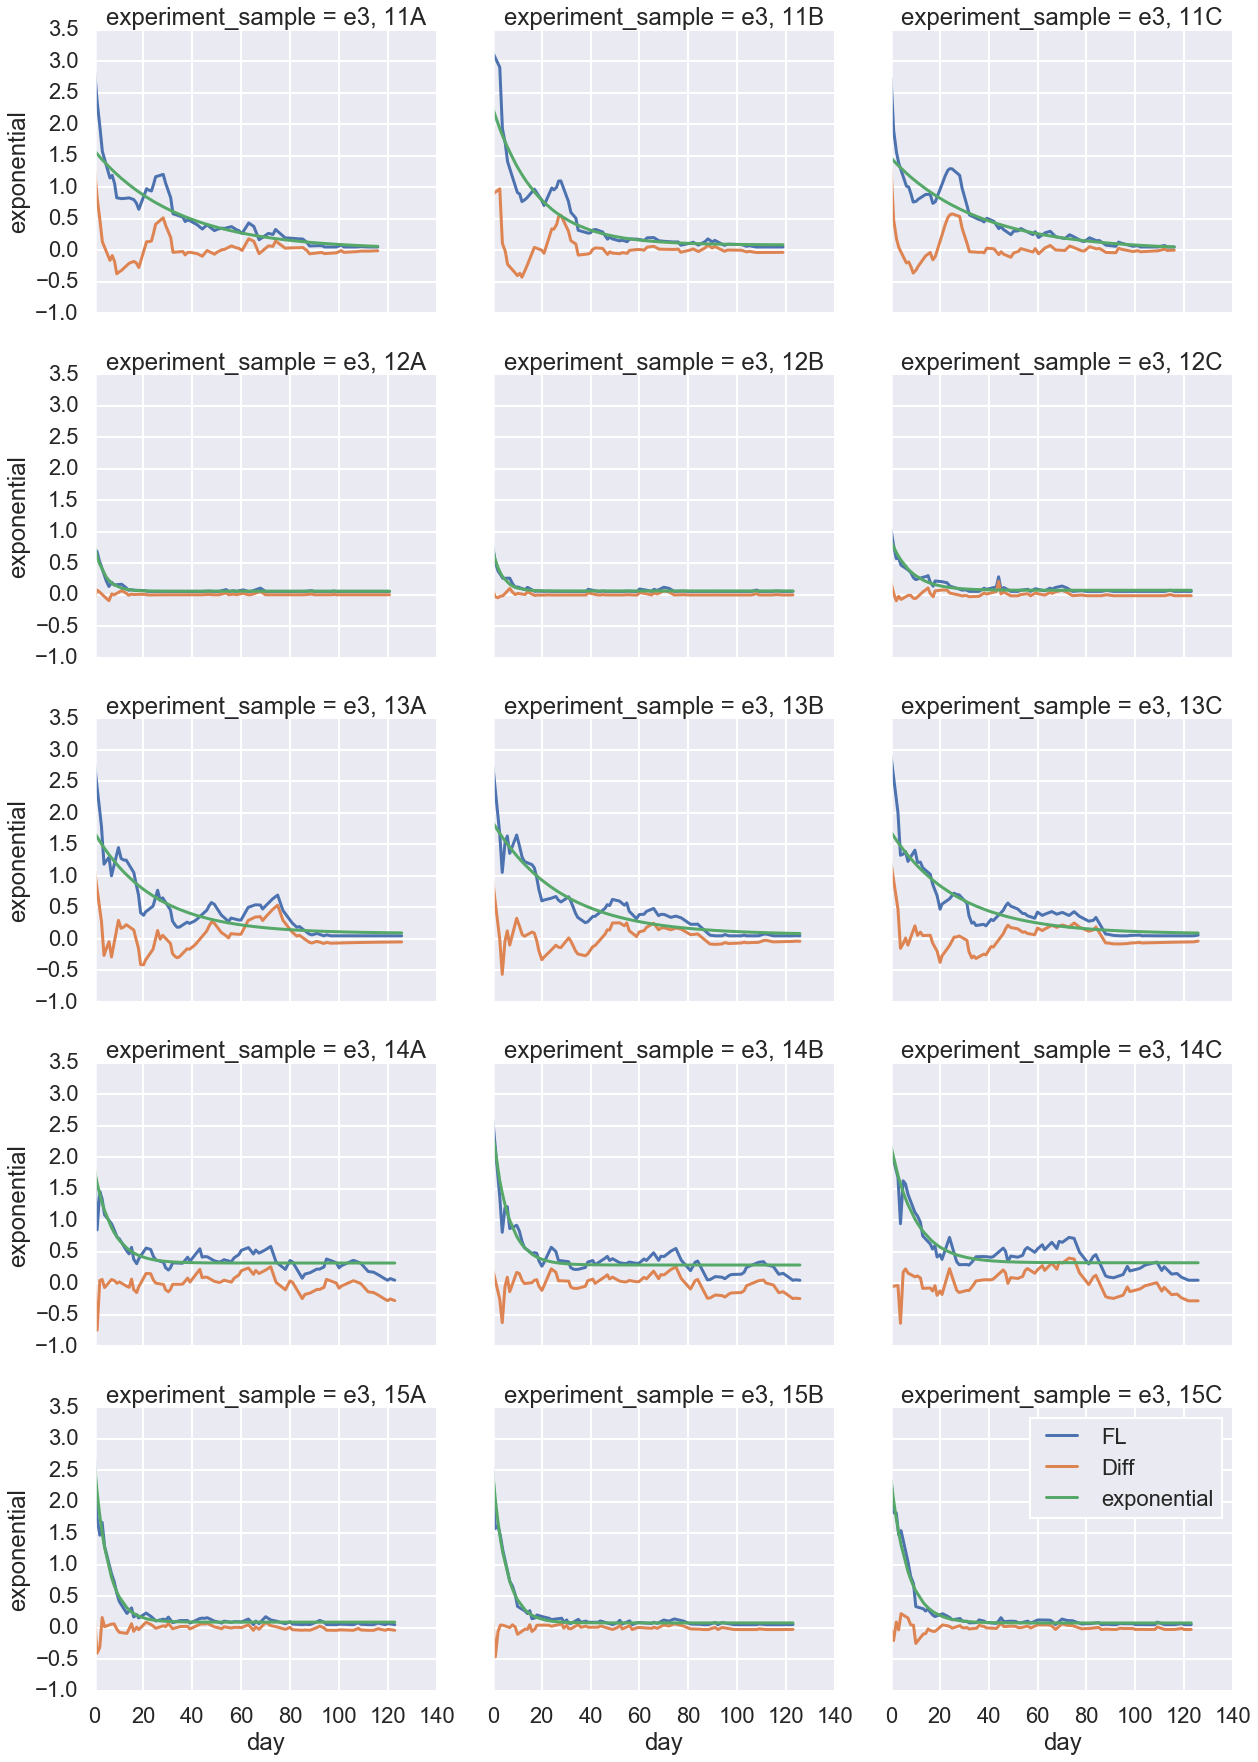

In [21]:
#for e in ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', ]:
#for e in ['e1' ]:

g = sns.FacetGrid(dfe.loc[(dfe.experiment.isin(['e3'])) & (dfe.culture == 'Co_Culture') & (dfe.ALT == 'DE1')], 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL', 'Diff']
cols.extend(method_cols)
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

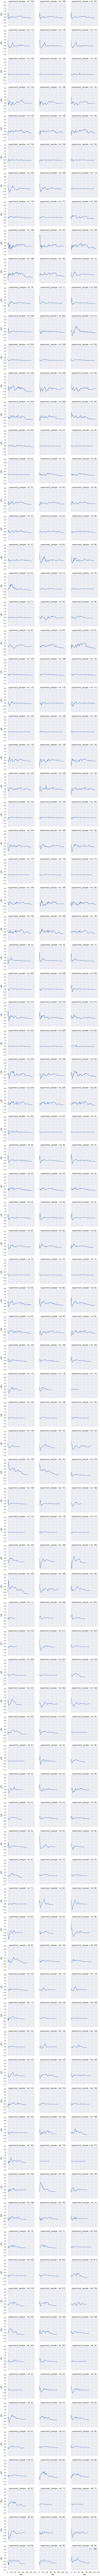

In [22]:
g = sns.FacetGrid(dfe, 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL', 'exponential', 'Diff']
cols =     ['Diff']
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

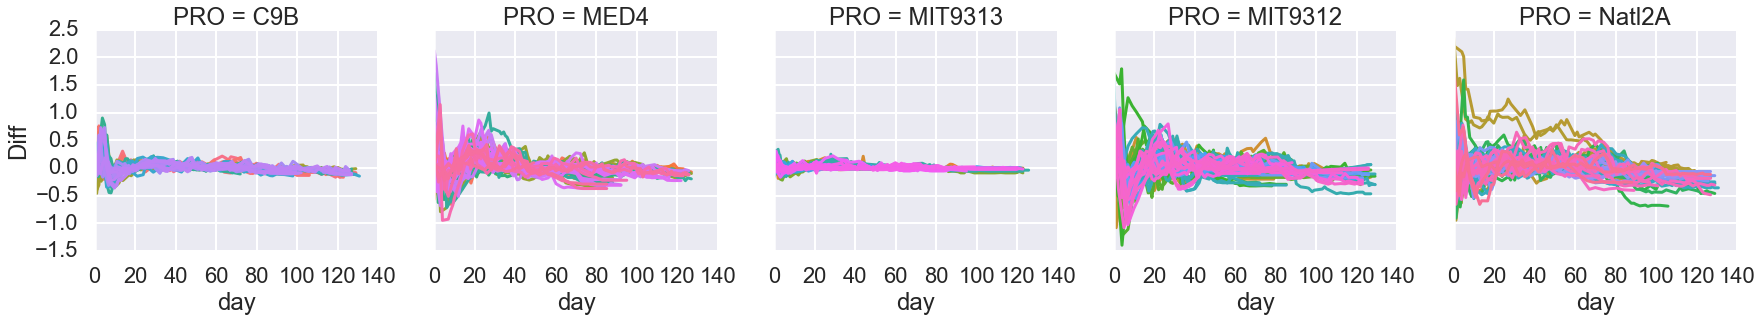

In [23]:
sns.relplot(data=dfe, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', 
            x='day', y='Diff', kind='line', hue='sample', legend=False)

In [24]:
X = cp.experiments2X(dfe, value_col='Diff')
metadf = cp.get_meta(dfe)
dfpca = cp.run_pca(X=X, metadf=metadf)


Variance percent explained
 [0.8456252  0.06482977]


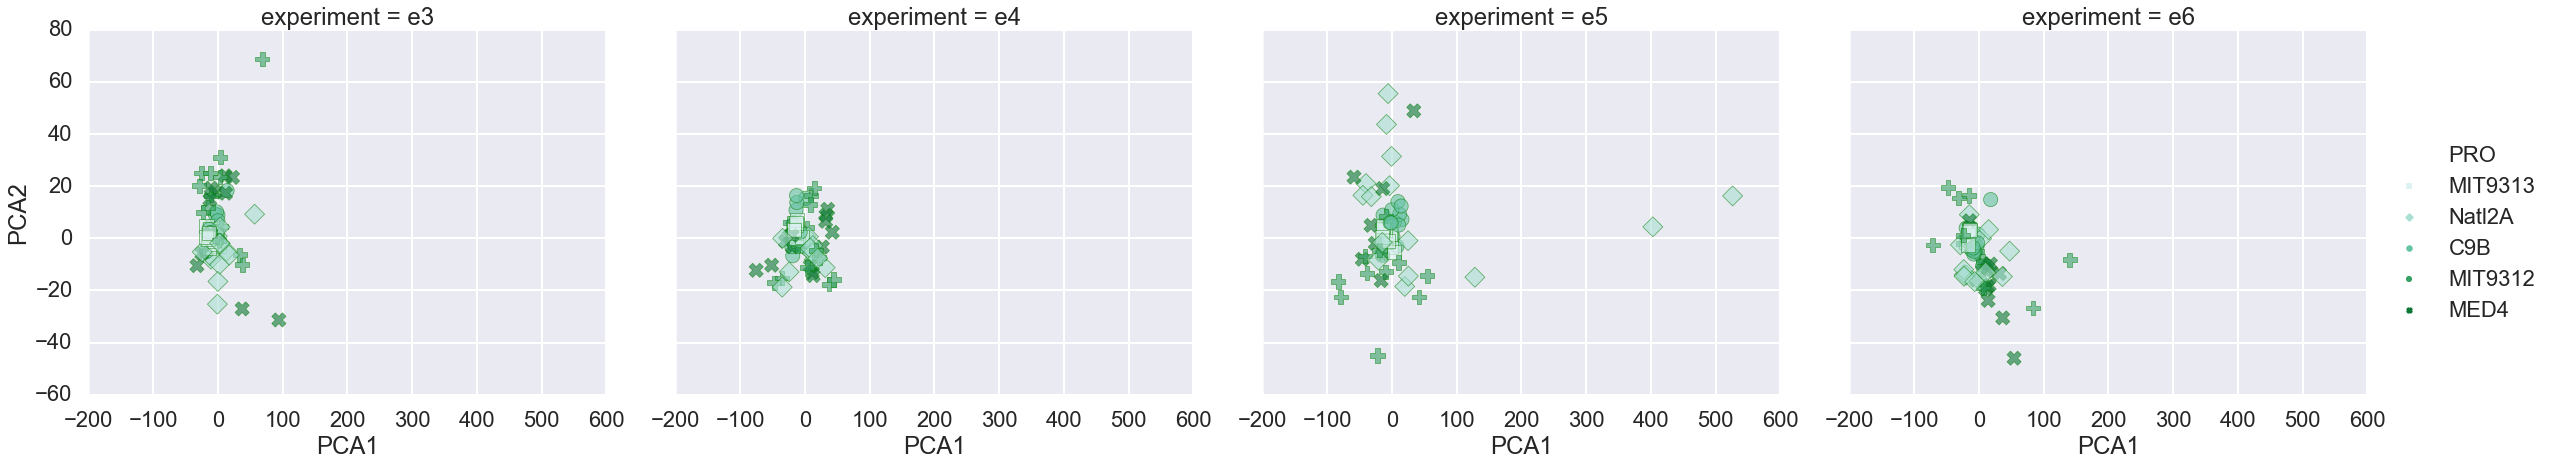

In [25]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            style='PRO', col='experiment',
            s=200, alpha=0.6, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [26]:
X = cp.experiments2X(dfe, value_col='Diff', cumsummode=False)
metadf = cp.get_meta(dfe)
dfpca = cp.run_pca(X=X, metadf=metadf)


Variance percent explained
 [0.29164662 0.22271325]


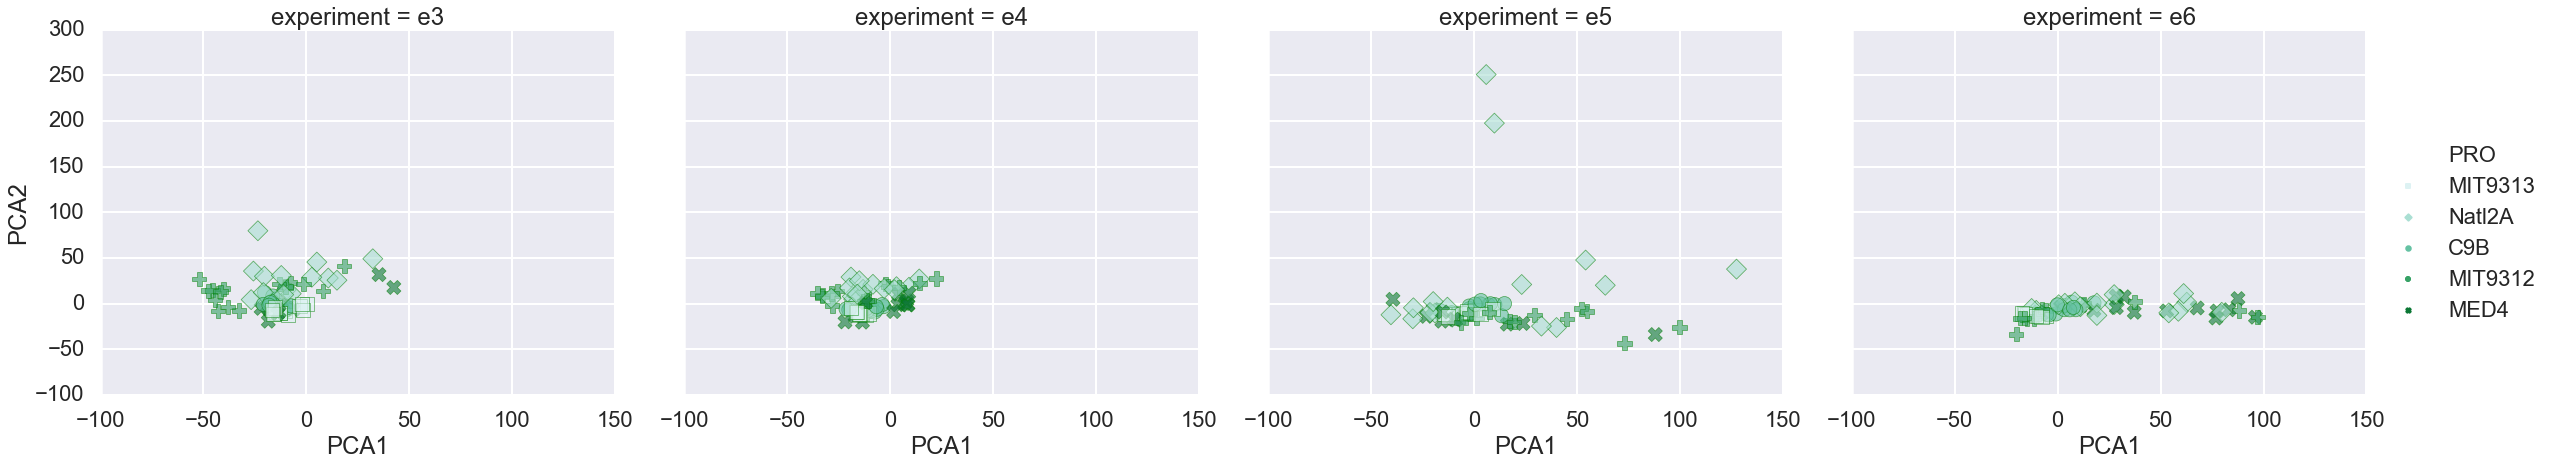

In [27]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            style='PRO', col='experiment',
            s=200, alpha=0.6, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [34]:
X.max().max(), X.mean().mean(), X.min().min()

(2.369, 0.011445790521617594, -1.3989633960979635)

In [51]:
X = cp.experiments2X(dfe, value_col='Diff', cumsummode=False)
y = metadf['PRO']
clf = cp.forest_classifier(X=X, y=y)

0.7185185185185186


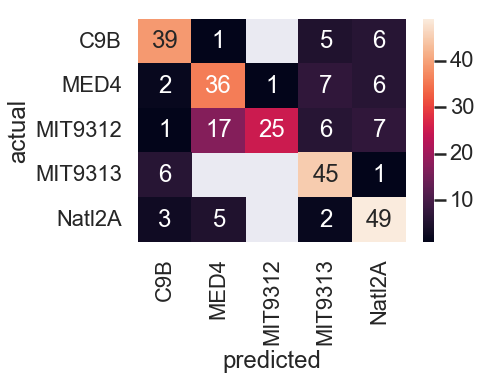

In [52]:
cp.forest_heatmap(clf=clf, X=X, y=y)

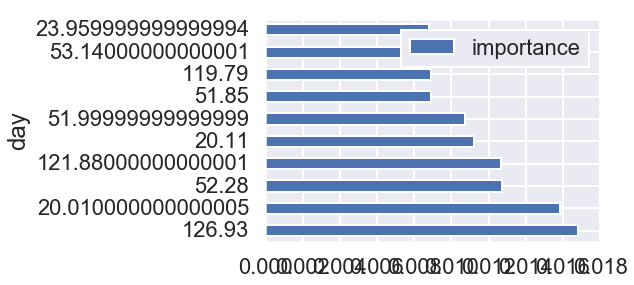

In [53]:
cp.forest_feature_importance(clf=clf, col_names=X.columns)

In [54]:
X = cp.experiments2X(dfe, value_col='FL', cumsummode=False)
y = metadf['PRO']
clf = cp.forest_classifier(X=X, y=y)

0.7185185185185186


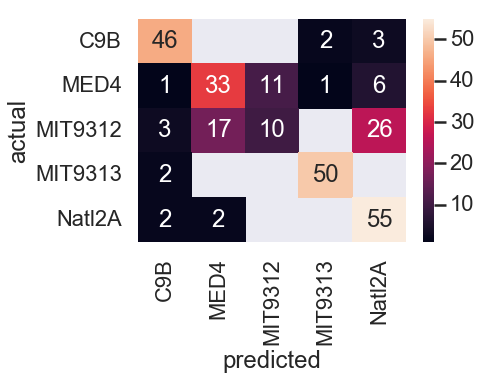

In [55]:
cp.forest_heatmap(clf=clf, X=X, y=y)

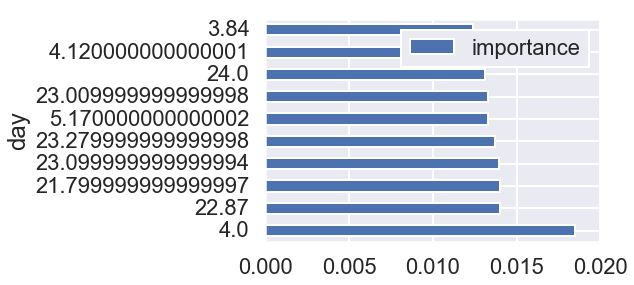

In [56]:
cp.forest_feature_importance(clf=clf, col_names=X.columns)

In [63]:
X1 = cp.experiments2X(dfe, value_col='Diff', cumsummode=False)
X2 = cp.experiments2X(dfe, value_col='FL', cumsummode=False)
X1.columns = 'Diff_' + X1.columns.astype(str)
X2.columns = 'FL_' + X2.columns.astype(str)
X = pd.concat([X1, X2], axis=1).fillna(0)
y = metadf['PRO'] + ', '+ metadf['ALT']
clf = cp.forest_classifier(X=X, y=y)

0.5481481481481482


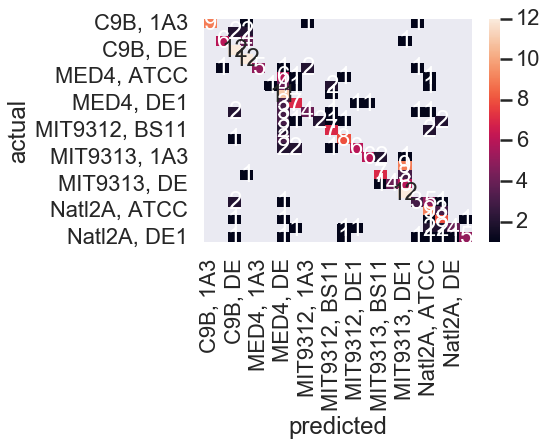

In [64]:
cp.forest_heatmap(clf=clf, X=X, y=y)

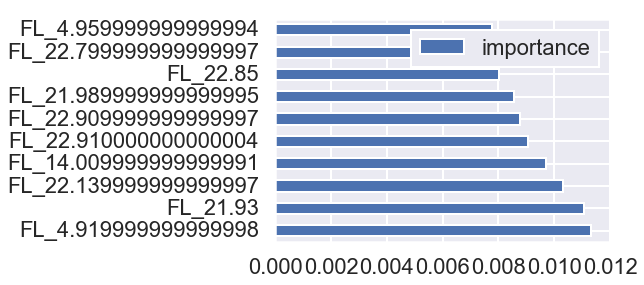

In [65]:
cp.forest_feature_importance(clf=clf, col_names=X.columns)